## Deep Learning with Noisy Labels for Spatio-Temporal Drought Detection

This notebook aims to provide users with the Spatio-Temporal Convolutional Encoder-Decoder (ST-CED) model trained with no label correction and with the SuperPixel-based Label Self-Correction (SPLSC) method. Users have the option to select from the different data splits and obtain the corresponding predictions.  

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%cd /home/jordi/Documents/erc/home/jorcora/STCEDroughts/
%ls 
#%conda create -n my_new_env -f STCEDroughts_2024.yml

%cd code
%ls

In [58]:
# Import required libraries
import os
import sys
import numpy as np
import argparse, yaml
import torch
import pickle
import zipfile
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# MODEL
from model.GDIS_model_indices import MY_MODEL
from model.arch import *

# UTILS
from utils.patch_map import M2P_P2M
from utils.loss import compute_loss
from utils.slice import crop_variable
from utils.spx import SPXsLABEL
from utils.GDIS_map import geoplot2d

In [59]:
def setup(filename):
    """Loads configuration yaml file as a dictionary

    :param filename: configuration file
    :type filename: yaml
    :return: configuration file
    :rtype: dict
    """    
    # Load YAML config file into a dict variable
    with open(filename) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python dictionary format
        config = yaml.load(file, Loader=yaml.FullLoader)

    return config

# Model and dataset configuration files
parent_path = os.path.dirname(os.getcwd())
dataset_config = setup(parent_path + '/configs/config_dataset.yaml')
model_config = setup(parent_path + '/configs/config_model.yaml')

# Select config files specific to model and fold
arch_name = '3D'
model_config['arch'].update(model_config['arch']['archs'][arch_name])
del model_config['arch']['archs']
print(model_config)

fold_id = 'F1'
dataset_config['GDIS'].update(dataset_config['GDIS']['folds'][fold_id])
del dataset_config['GDIS']['folds']
print(dataset_config)

# To determine the paths let's create another config 
experiment_config = {}
experiment_config['Arguments'] = {}
experiment_config['Arguments']['print_format'] = 'pdf'
experiment_config['Arguments']['images_spx_path'] = parent_path + '/notebook/outputs'

{'arch': {'name': 'SHIFT4L', 'model_init_file': '3Ds0', 'num_classes': 1, 'in_channels_climate': 5, 'encoder_1': 16, 'encoder_2': 32, 'encoder_3': 64, 'encoder_4': 128, 'decoder_4': 128, 'decoder_3': 64, 'decoder_2': 32, 'decoder_1': 16, 'slope': 0.1, 'dropout': 0.1, 'momentum': 0.1, 'PI': 0.01, 'conv_kernel_size': '(2,3,3)', 'last_conv_kernel_size': '(1,3,3)', 'pool_kernel_size': '(1,2,2)'}, 'SPX': {'SPX': 0, 'split_method': 'slic', 'npixels': 25, 'metric': 'mean', 'metric_eps_score': 'conf_score_entr', 'time_weight': True, 'softLabels': True, 'combined_labels': True, 'combined_losses': False, 'eps': 0.05, 'robustness': {'noise_level': 0.0, 'id_process': 0, 'n_process': 10, 'gen_id': 0}}, 'optimizer': {'lr': 0.001, 'wd': 0.0, 'loss': {'type': 'FL', 'gamma': 1}}, 'trainer': {'epochs': 10, 'monitor': 'auroc', 'mselection': 'mselection', 'early_stop': 500}}
{'GDIS': {'root': '/home/jorcora/Location_Aware_AM/databases/GDIS', 'data_file': 'esdc-8d-0.083deg-1x2160x4320-2.1.1', 'labels_file'

In [60]:
# Load the demo data 
path_data = f'{parent_path}/notebook/demo_data.zip'
with zipfile.ZipFile(path_data, 'r') as zip_ref:
        zip_ref.extractall(f'{parent_path}/notebook/')

/tmp/ipykernel_15434/2186339999.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  axs.contour(demo_labels[0,0,0,0,:,:], colors = 'k', linewidth = 2.5)


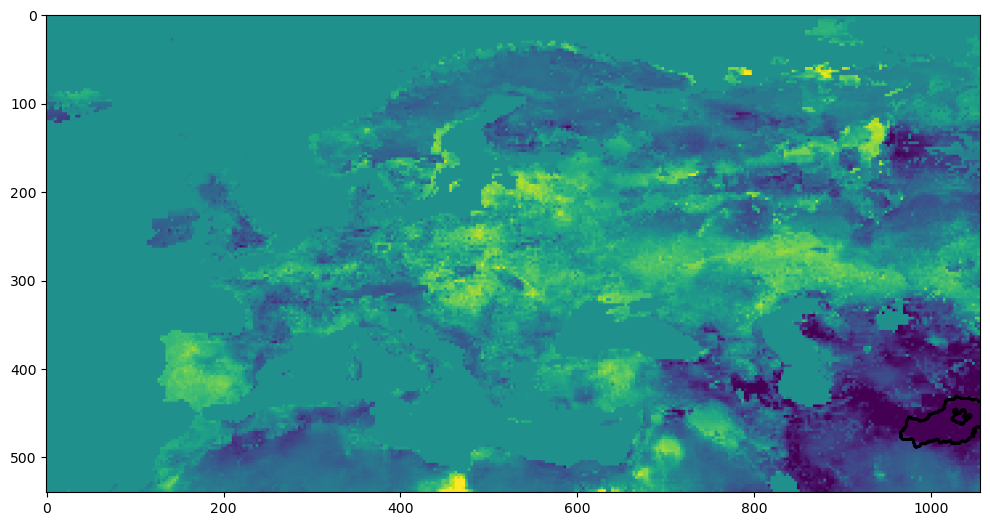

In [61]:
path_data = f'{parent_path}/notebook/demo_data_{fold_id}.pkl'
with open(path_data, "rb") as f:
        demo_data = pickle.load(f)

# Split into variables
demo_x = torch.from_numpy(np.array(demo_data['demo_x']))
demo_masks = torch.from_numpy(np.array(demo_data['demo_masks']))
demo_labels = torch.from_numpy(np.array(demo_data['demo_labels']))
tsize = demo_x.shape[0]

# Show an example 
size = demo_labels.shape[3]
fig, axs = plt.subplots(1, 1, figsize=(10, 14))
axs.imshow(demo_x[0,0,0,0,:,:]), 
axs.contour(demo_labels[0,0,0,0,:,:], colors = 'k', linewidth = 2.5)
plt.tight_layout()  
plt.show()
plt.close(fig = fig)

In [62]:
# Initialize the model
model = MY_MODEL(experiment_config, dataset_config, model_config)
print(model)

# Load the pretrained models
pretrained_model_path = f'{parent_path}/notebook/pretrained_Models/{fold_id}'
model_NL = model.load_from_checkpoint(pretrained_model_path + '_NL.ckpt')
model_SPLSC = model.load_from_checkpoint(pretrained_model_path + '_SPLSC.ckpt') # dataset_config = dataset_config

Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../notebook/pretrained_Models/F1_NL.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../notebook/pretrained_Models/F1_SPLSC.ckpt`


Model: SHIFT4L
MY_MODEL(
  (model): SHIFT4L(
    (encoder_conv_1): Conv3d(5, 16, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (encoder_conv_2): Conv3d(16, 32, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (encoder_conv_3): Conv3d(32, 64, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (encoder_conv_4): Conv3d(64, 128, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (encoder_bn_1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (encoder_bn_2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (encoder_bn_3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (encoder_bn_4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (decoder_conv_4): Conv3d(128, 64, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (decoder_conv_3): Conv3d(64, 32, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (decoder_conv_2): Conv3d(32, 16, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (de

In [63]:
# >>> Save outputs and predicctions for evaluation against indices
results_maps = {'y_hat_NL':[], 'y_hat_SPLSC':[], 'labels': [], 'masks':[]}
    
# To correct for missing positions in the output
size_in = list(eval(dataset_config['GDIS']['input_size']))
size_out = list(eval(dataset_config['GDIS']['output_size']))
lost_border = int((size_in[0] - size_out[0])/2) 
idt = dataset_config['GDIS']['idt']

# Visualization variables for georeferenced plots
# img_extent = [minlon, maxlon, minlat, maxlat] coordinates where the data is defined
vismargin = dataset_config['GDIS']['vismargin']
resolution_adjust = int((size_in[0] - size_out[0])/2) * dataset_config['GDIS']['resolution']    
resolution_adjustvismargin = vismargin * dataset_config['GDIS']['resolution']
im_extent = (eval(dataset_config['GDIS']['lon_slice'])[0] + resolution_adjust, 
                eval(dataset_config['GDIS']['lon_slice'])[1] - resolution_adjustvismargin,
                eval(dataset_config['GDIS']['lat_slice'])[1] + resolution_adjustvismargin,
                eval(dataset_config['GDIS']['lat_slice'])[0] - resolution_adjust)   

# Central latitude and longitude
central_longitude = (im_extent[1] - abs(im_extent[0]))/2
central_latitude = (im_extent[3] - abs(im_extent[2]))/2
projection = ccrs.LambertConformal(central_longitude = central_longitude, 
                                   central_latitude = central_latitude)

In [64]:
# Set model to evaluate
model_NL.eval()
model_SPLSC.eval()
with torch.no_grad():

    # Loop over the demo dataset
    for i in np.arange(tsize):
        print('Sample', i)
        
        # Get samples
        x = demo_x[i]
        masks = demo_masks[i]
        labels = demo_labels[i]

        # Evaluate 
        res_NL = model_NL.evaluate_map(x, masks, labels, mode = 'test')
        res_SPLSC = model_SPLSC.evaluate_map(x, masks, labels, mode = 'test')

        # Adapt masks to the output size
        masks = masks[:,:,:,lost_border:,lost_border:]
        masks = crop_variable(dataset_config['GDIS'], masks, temporal_crop = True)

        # Converto to numpy, select time frame and remove extra dimensions (batch and variable)
        # we take the first temporal instance
        y_hat_NL = res_NL['output'][0,0,idt].cpu().numpy()
        y_hat_SPLSC = res_SPLSC['output'][0,0,idt].cpu().numpy()
        labels = res_NL['labels'][0,0,idt].cpu().numpy()
        masks = masks[0,0,idt].cpu().numpy()

        # For the missing positions 
        y_hat_NL[masks == 0] = np.nan
        y_hat_SPLSC[masks == 0] = np.nan

        # Save output
        results_maps['y_hat_NL'].append(np.copy(y_hat_NL))
        results_maps['y_hat_SPLSC'].append(np.copy(y_hat_SPLSC))
        results_maps['labels'].append(np.copy(labels))
        results_maps['masks'].append(np.copy(masks))

Sample 0
Sample 1
Sample 2


Sample 0


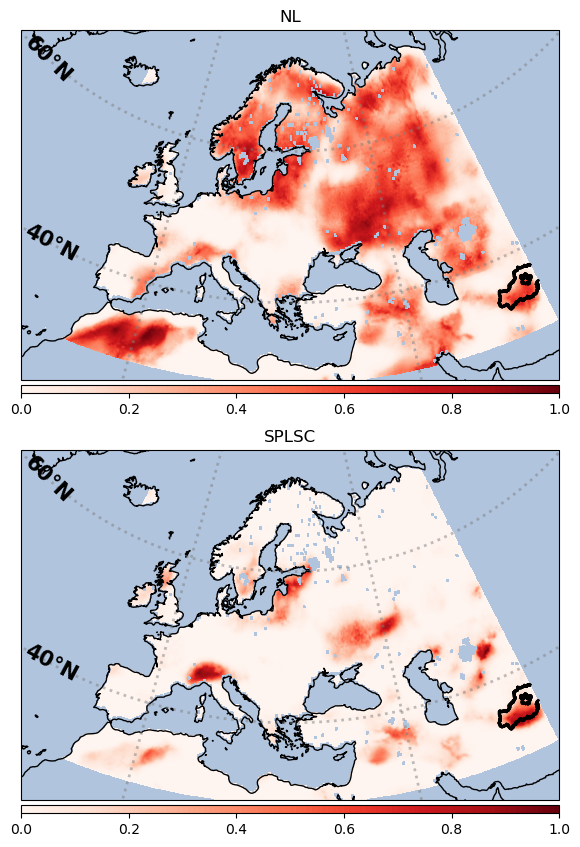

Sample 1


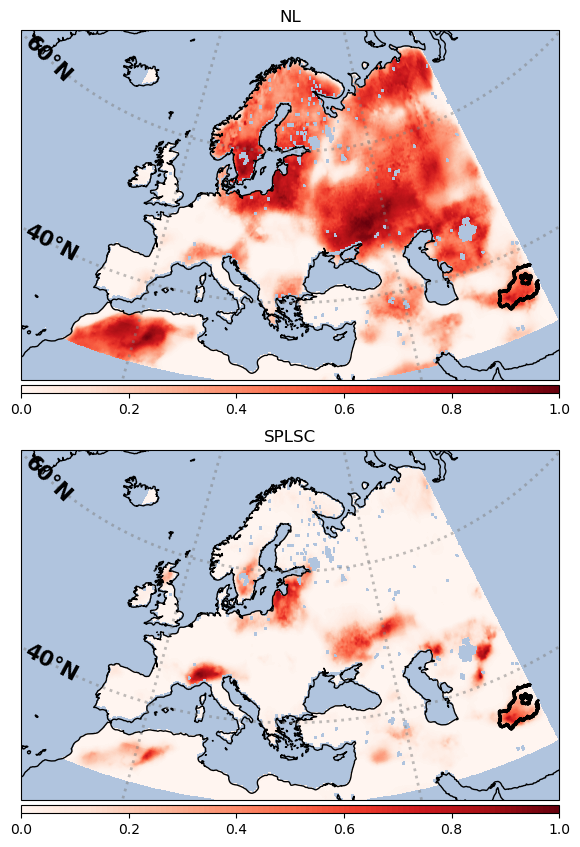

Sample 2


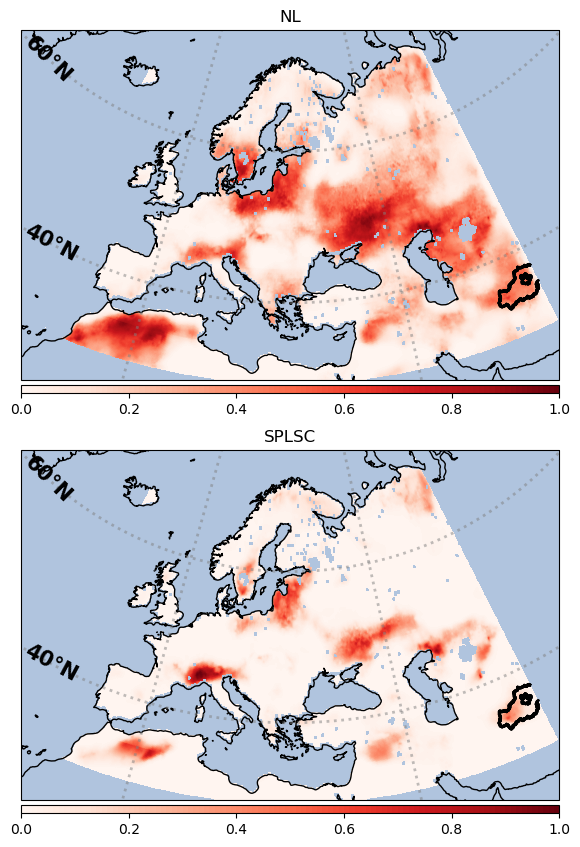

In [65]:
# Normalize the maps according to the max prob of each model (for comparing between them)            
NL_min = np.nanmin(results_maps['y_hat_NL'])
NL_max = np.nanmax(results_maps['y_hat_NL'])
SPLSC_min = np.nanmin(results_maps['y_hat_SPLSC'])
SPLSC_max = np.nanmax(results_maps['y_hat_SPLSC'])

plot_maps_NL = (results_maps['y_hat_NL'] - NL_min) / (NL_max - NL_min)
plot_maps_SPLSC = (results_maps['y_hat_SPLSC'] - SPLSC_min) / (SPLSC_max - SPLSC_min)

#Plot label map
for i in np.arange(tsize):
    print('Sample', i)
    
    # Plot    
    fig = plt.figure(figsize = (10, 10)) 
    ax1 = plt.subplot(2, 1, 1, projection = projection)
    ax2 = plt.subplot(2, 1, 2, projection = projection)  
    im1 = geoplot2d(ax1, plot_maps_NL[i], im_extent, im_contour = results_maps['labels'][i])
    im2 = geoplot2d(ax2, plot_maps_SPLSC[i], im_extent, im_contour = results_maps['labels'][i])
    ax1.title.set_text('NL')
    ax2.title.set_text('SPLSC')
    plt.savefig(f"{experiment_config['Arguments']['images_spx_path']}/{fold_id}_t_{i}.{experiment_config['Arguments']['print_format']}", 
                format = experiment_config['Arguments']['print_format'], bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    plt.close(fig = fig)